<a href="https://colab.research.google.com/github/jeongrok/graphdata_analysis/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CSE/CSE 6740

MessageError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import sklearn as sk
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [ ]:
smiles_data = pd.read_csv('classification.csv')

FileNotFoundError: ignored

In [ ]:
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'n', 'o', 'p', 'r',
                's', 't', 'u']

smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )

def smiles_encoder( smiles, maxlen=200):
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    Y = np.zeros(maxlen)
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
        Y[i] = smi2index[c]
    return X, Y

def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi

In [ ]:
maxlen = 600
mol = smiles_data.iloc[:,0].to_numpy()
label = smiles_data.iloc[:,1].to_numpy()

mol_svm = np.zeros((mol.shape[0],maxlen))

for j in range(mol.shape[0]):
  X, Y = smiles_encoder(mol[j],maxlen)
  mol_svm[j,:] = Y

svm_train = mol_svm[0:30000,:]
svm_test = mol_svm[30000:,:]

mol_train = mol_svm[0:30000,:]
mol_test = mol_svm[30000:,:]

label_train = label[0:30000]
label_test = label[30000:]

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
clf_linear = make_pipeline(StandardScaler(), LinearSVC(dual=bool(0), random_state=0, C=0.05, tol=1e-4, max_iter=5000))
clf_linear.fit(svm_train, label_train)

y_train_pred = clf_linear.predict(svm_train)
y_test_pred = clf_linear.predict(svm_test)

train_f1 = metrics.f1_score(label_train, y_train_pred)
test_f1 = metrics.f1_score(label_test, y_test_pred)

print(train_f1, test_f1)

0.07587548638132295 0.03266787658802178


In [ ]:
clf_kernel = make_pipeline(StandardScaler(), sk.svm.SVC(gamma='auto', kernel='rbf', C=10000, tol=1e-4))
clf_kernel.fit(svm_train, label_train)

y_train_pred = clf_kernel.predict(svm_train)
y_test_pred = clf_kernel.predict(svm_test)

train_f1 = metrics.f1_score(label_train, y_train_pred)
test_f1 = metrics.f1_score(label_test, y_test_pred)

print(train_f1, test_f1)

0.8937360178970918 0.08695652173913042


In [ ]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(mol_svm.astype(np.float32))
        self.y = torch.from_numpy(label.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

batch_size = 64

# Instantiate training and test data
train_data = Data(mol_train, label_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(mol_test, label_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
input_dim = 600
hidden_dim = 300
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_dim, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, 150, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(150, 75, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(75, 32, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(32, output_dim, bias=True),
                                )

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.sigmoid(x)
        return x

model = NeuralNetwork(input_dim, hidden_dim, output_dim)

In [ ]:
learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


'\nTraining Complete\n'

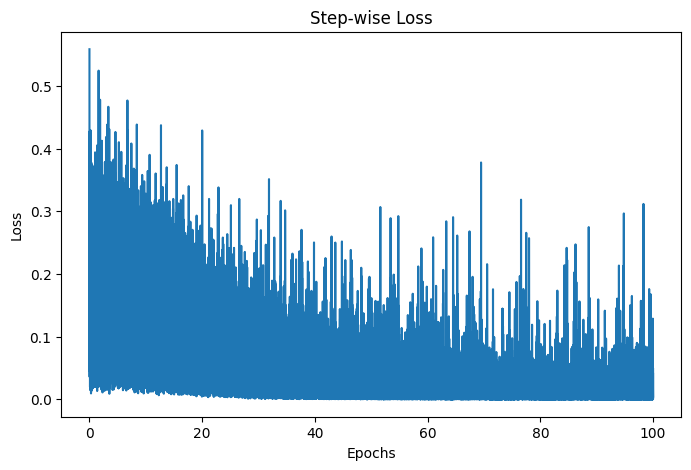

In [ ]:
step = np.linspace(0, 100, 65500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in train_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)

y_pred_flat = []
for sublist in y_pred:
    for item in sublist:
        y_pred_flat.append(item)

y_test_flat = []
for sublist in y_test:
    for item in sublist:
        y_test_flat.append(int(item))

train_f1 = metrics.f1_score(y_test_flat, y_pred_flat)

y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)

y_pred_flat = []
for sublist in y_pred:
    for item in sublist:
        y_pred_flat.append(item)

y_test_flat = []
for sublist in y_test:
    for item in sublist:
        y_test_flat.append(int(item))

test_f1 = metrics.f1_score(y_test_flat, y_pred_flat)

In [ ]:
print(train_f1, test_f1)

0.897973950795948 0.897973950795948
